# Predicting Monetary Policy Changes using NLP

## Step 3: analysis of statement sentiment by lexicon

Goals of this notebook:
+ Create and improve specific dictionaries
+ Build a sentiment indicator of monetary policy
+ Asses if there is a relationship between economy and net sentiment

In [157]:
# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
import datetime as dt
from functools import reduce


# Import NLP modules
import re
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import spacy

data_path = '/home/renatovassallo/Omega/BSE/Term2/Textmining/term_paper/Data'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renatovassallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/renatovassallo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/renatovassallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Explore the text

In [158]:
df_text = pd.read_csv(data_path+'/text_data_per.csv')
# Dictionary tone assessment will compare them by Index (need the numbers back) 
df_text['Index'] = range(0, len(df_text))
print(df_text.shape)
df_text.head()

(242, 4)


,statement,date,text,Index
0,Nota-Informativa-001-2003-BCRP.pdf,2003-01-01,Nota de Prensa DIRECTORIO DEL BCR APR...,0
1,Nota-Informativa-002-2003-BCRP.pdf,2003-02-01,Nota de Prensa DIRECTORIO DEL BCR APR...,1
2,Nota-Informativa-003-2003-BCRP.pdf,2003-03-01,Nota de Prensa DIRECTORIO DEL BCR APR...,2
3,Nota-Informativa-004-2003-BCRP.pdf,2003-04-01,Nota de Prensa PROGRAMA MONETARIO ...,3
4,Nota-Informativa-005-2003-BCRP.pdf,2003-05-01,Nota de Prensa DIRECTORIO DEL BCR ...,4


In [159]:
nlp = spacy.load('es_core_news_sm', exclude=["ner"])
stop = list(nlp.Defaults.stop_words)

# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [160]:
corpus = create_corpus(df_text)
x, y = get_frequent_stop_words(corpus)
w, z = get_frequent_nonstop_words(corpus)

print('Frequent stopwords: \n')
print(x)
print(y)
print('-----------------------')
print('Non-Frequent stopwords: \n')
print(w)
print(z)

Frequent stopwords: 

('de', 'la', 'en', 'por', 'el', 'y', 'a', 'del', 'se', 'las')
(12329, 5096, 4534, 3631, 3301, 2358, 2257, 2148, 2092, 1692)
-----------------------
Non-Frequent stopwords: 

('inflación', 'tasa', 'ciento', 'interés', 'directorio', 'operaciones', 'ciento.', 'referencia', 'bcrp', 'monetario')
(1696, 1631, 1512, 1180, 853, 830, 662, 599, 526, 505)


<AxesSubplot:>

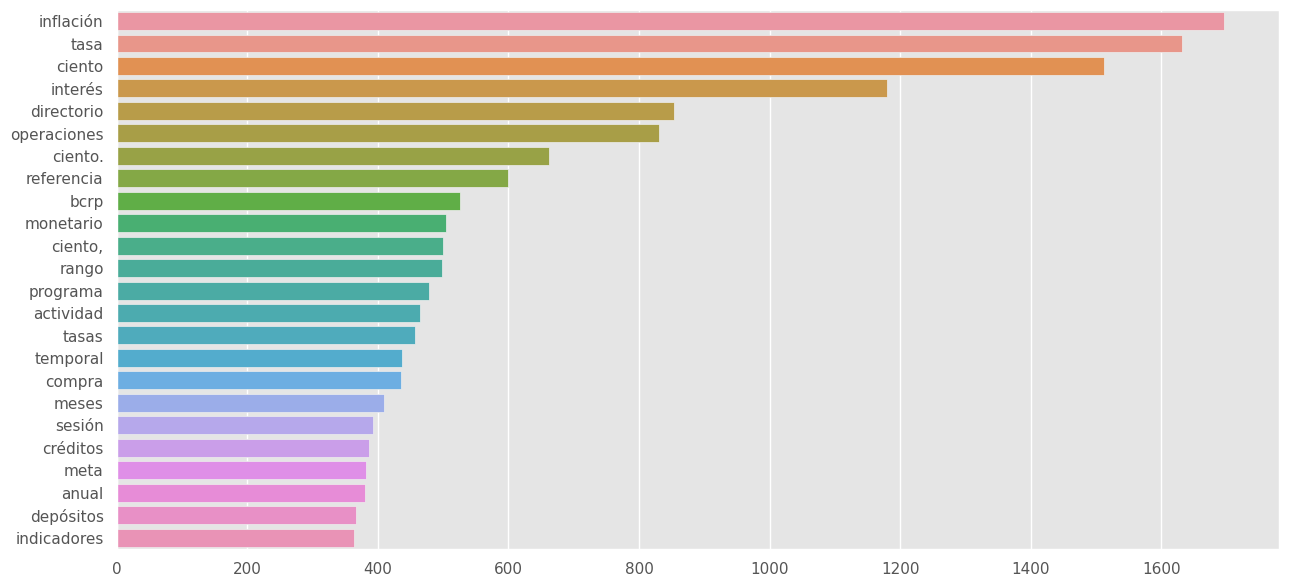

In [161]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:45]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

## Approach 1: sentiment based on Loughran and McDonald dictionary

In [162]:
# Load sentiment data
sentiment_spanish = pd.read_csv(data_path+'/spanish_dictionary.csv')
sentiment_spanish['sentiment'].value_counts()

negative    1525
positive     335
Name: sentiment, dtype: int64

In [163]:
# Create a dictionary
sentiments = sentiment_spanish['sentiment'].unique()
sentiment_dict = { sentiment: sentiment_spanish.loc[sentiment_spanish['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

#### Analyze the tone with negation without lemmatization

In [164]:
# Consider Negation
negate_es = ["no pudo", "no se pudo", "no es", "no podría", "no debe","ninguno", "no", "no podrá", "no debería", "no necesita", 
           "nunca", "ninguno", "ni", "nada", "no necesitaría", "no fue", "no era", "sin", "no lo haría", "no habría",
           "no lo hará", "rara vez", "a pesar de", "nadie", "no se habría"]

negate_en = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate_es:
        return True
    else:
        return False
    
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0
    net_sent = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
        net_sent = pos_count - neg_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, net_sent, pos_words, neg_words]
 
    return results

columns = ['tone_LM', 'word_count', 'n_pos_words', 'n_neg_words', 'net_sent', 'pos_words', 'neg_words']

In [165]:
# Analyze tone for original text dataframe
print(df_text.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(df_text['text'], total=df_text.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
tone_lmdict_df['Index'] = range(0, len(tone_lmdict_df))
df_approach1 = pd.merge(df_text, tone_lmdict_df, on='Index')
df_approach1

(242, 4)


/tmp/ipykernel_1426/548170040.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(df_text['text'], total=df_text.shape[0])]


  0%|          | 0/242 [00:00<?, ?it/s]

,statement,date,text,Index,tone_LM,word_count,n_pos_words,n_neg_words,net_sent,pos_words,neg_words
0,Nota-Informativa-001-2003-BCRP.pdf,2003-01-01,Nota de Prensa DIRECTORIO DEL BCR APR...,0,0.000000,391,4,4,0,"[lograr, arriba, crecimiento, crecimiento]","[abajo, inferior, riesgo, embargo]"
1,Nota-Informativa-002-2003-BCRP.pdf,2003-02-01,Nota de Prensa DIRECTORIO DEL BCR APR...,1,0.611621,327,5,3,2,"[lograr, arriba, aumento, crecimiento, efectivo]","[convocar, abajo, implica]"
2,Nota-Informativa-003-2003-BCRP.pdf,2003-03-01,Nota de Prensa DIRECTORIO DEL BCR APR...,2,0.000000,329,4,4,0,"[aumento, lograr, arriba, efectivo]","[dificultades, riesgo, abajo, implica]"
3,Nota-Informativa-004-2003-BCRP.pdf,2003-04-01,Nota de Prensa PROGRAMA MONETARIO ...,3,0.304878,328,5,4,1,"[aumento, arriba, superior, mayor, efectivo]","[embargo, excluye, abajo, implica]"
4,Nota-Informativa-005-2003-BCRP.pdf,2003-05-01,Nota de Prensa DIRECTORIO DEL BCR ...,4,0.000000,314,3,3,0,"[crecimiento, arriba, efectivo]","[excluye, abajo, implica]"
...,...,...,...,...,...,...,...,...,...,...,...
237,nota-informativa-2022-10-06-1.pdf,2022-10-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE OCTUBRE...,237,0.649351,462,8,5,3,"[superior, aumento, fuerte, superior, mayor, c...","[conflictos, fuerte, disminuyendo, conflictos,..."
238,nota-informativa-2022-11-10-1.pdf,2022-11-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE NOVIEMB...,238,0.662252,453,8,5,3,"[superior, aumento, fuerte, superior, mayor, c...","[conflictos, fuerte, disminuyendo, conflictos,..."
239,nota-informativa-2022-12-07-1.pdf,2022-12-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE DICIEMB...,239,0.622407,482,8,5,3,"[superior, aumento, fuerte, superior, mayor, c...","[conflictos, fuerte, disminuyendo, conflictos,..."
240,nota-informativa-2023-01-12-1.pdf,2023-01-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE ENERO 2...,240,0.441501,453,7,5,2,"[superior, aumento, fuerte, superior, mayor, c...","[conflictos, fuerte, disminuyendo, conflictos,..."


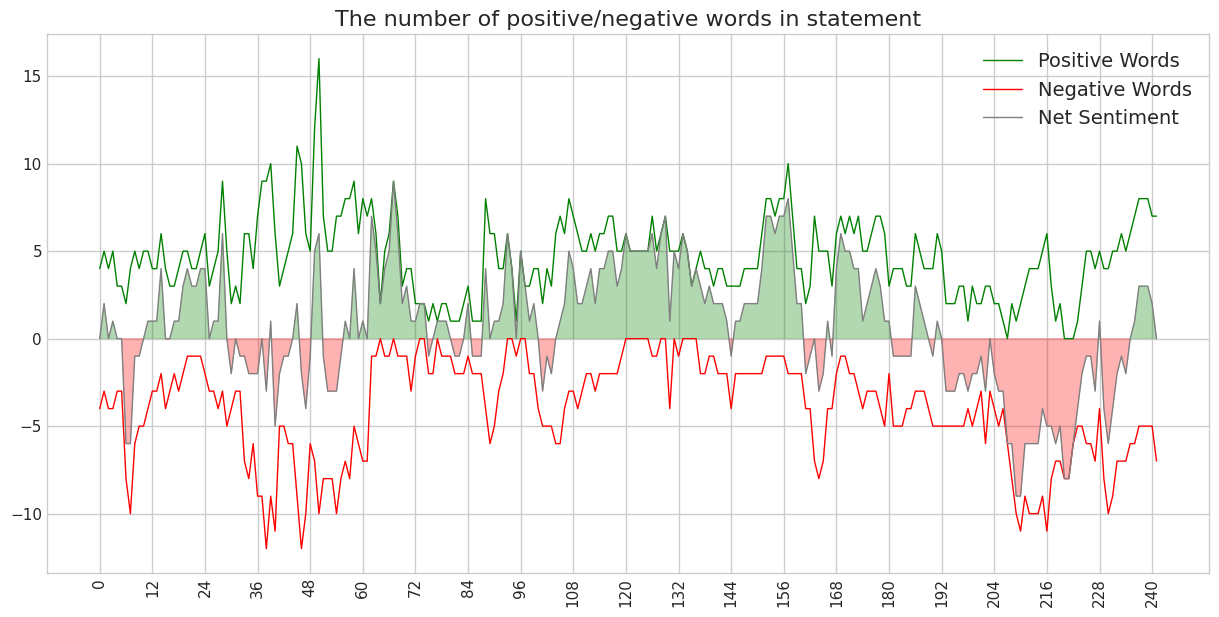

In [166]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(df_approach1.index, df_approach1['n_pos_words'], c='green', linewidth= 1.0)
plt.plot(df_approach1.index, df_approach1['n_neg_words']*-1, c='red', linewidth=1.0)
plt.plot(df_approach1.index, df_approach1['net_sent'], c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(df_approach1.index, df_approach1['net_sent'], where=(df_approach1['net_sent'] > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(df_approach1.index, df_approach1['net_sent'], where=(df_approach1['net_sent'] <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
half_year_locator = mdates.MonthLocator(interval=6)  # every month
year_formatter = mdates.DateFormatter('%Y')

plt.xticks(np.arange(0,len(df_approach1.text),12), rotation = 'vertical')

ax.grid(True)

plt.show()

Positive and negative word counts highly correlated probably because of the total number of words varies. Take the positive - negative as Net Sentiment.

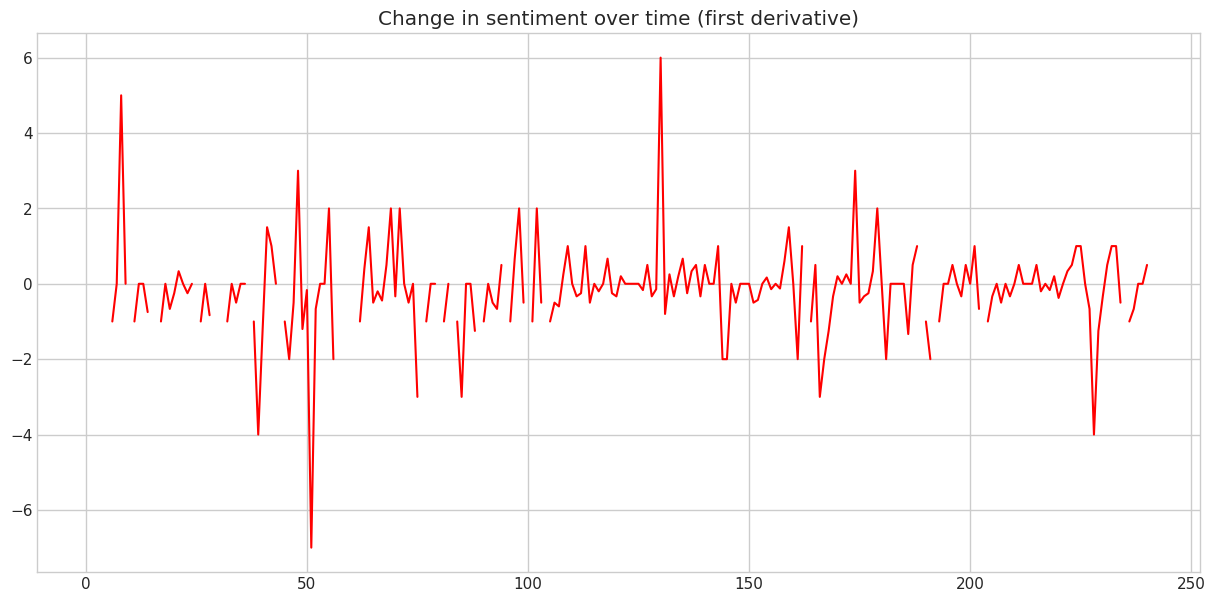

In [169]:
firstderivative = (df_approach1['net_sent'].shift(1) - df_approach1['net_sent']) / df_approach1['net_sent']

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(df_approach1.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.


plt.show()

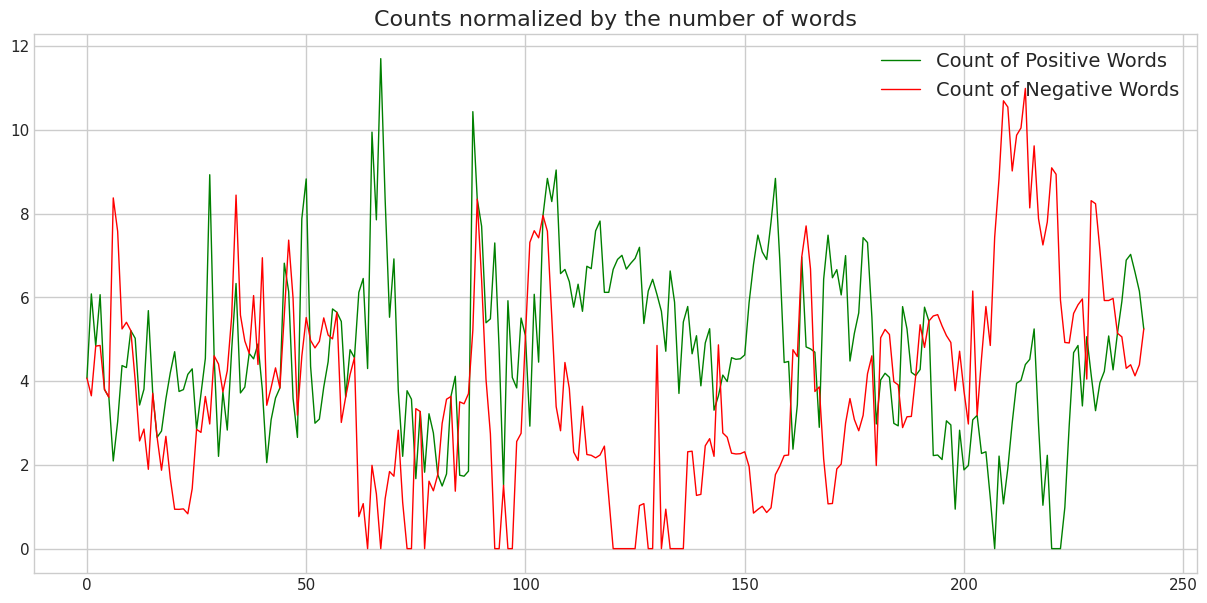

In [170]:
# Normalize data
NPositiveWordsNorm = df_approach1['n_pos_words'] / df_approach1['word_count'] * np.mean(df_approach1['word_count'])
NNegativeWordsNorm = df_approach1['n_neg_words'] / df_approach1['word_count'] * np.mean(df_approach1['word_count'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_approach1.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(df_approach1.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )


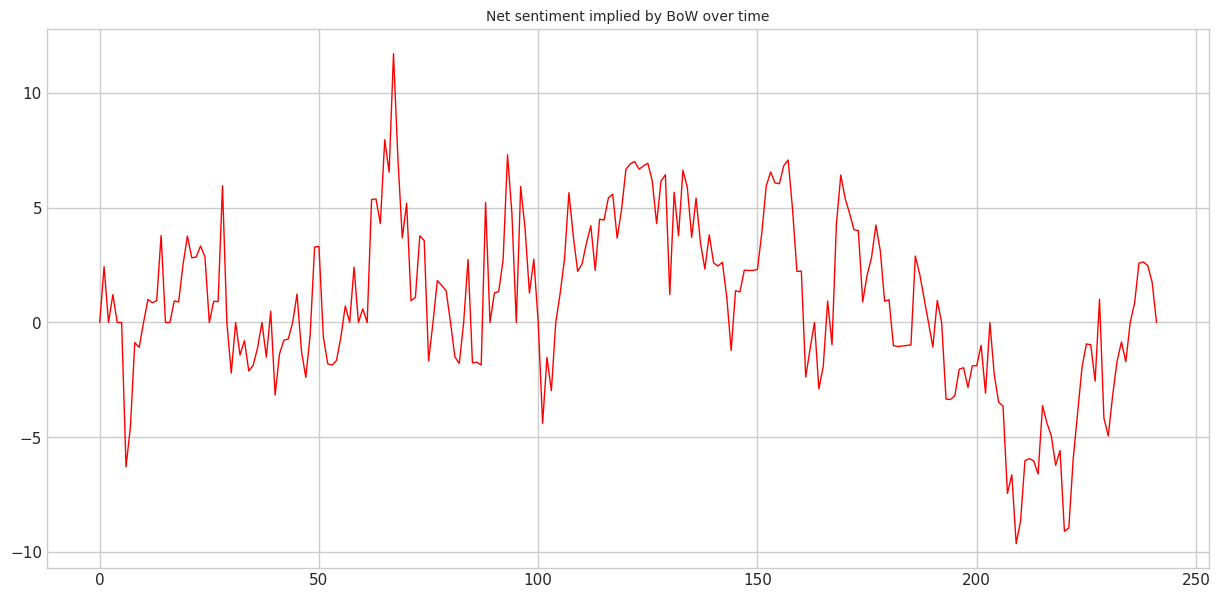

In [172]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_approach1.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')
plt.show()

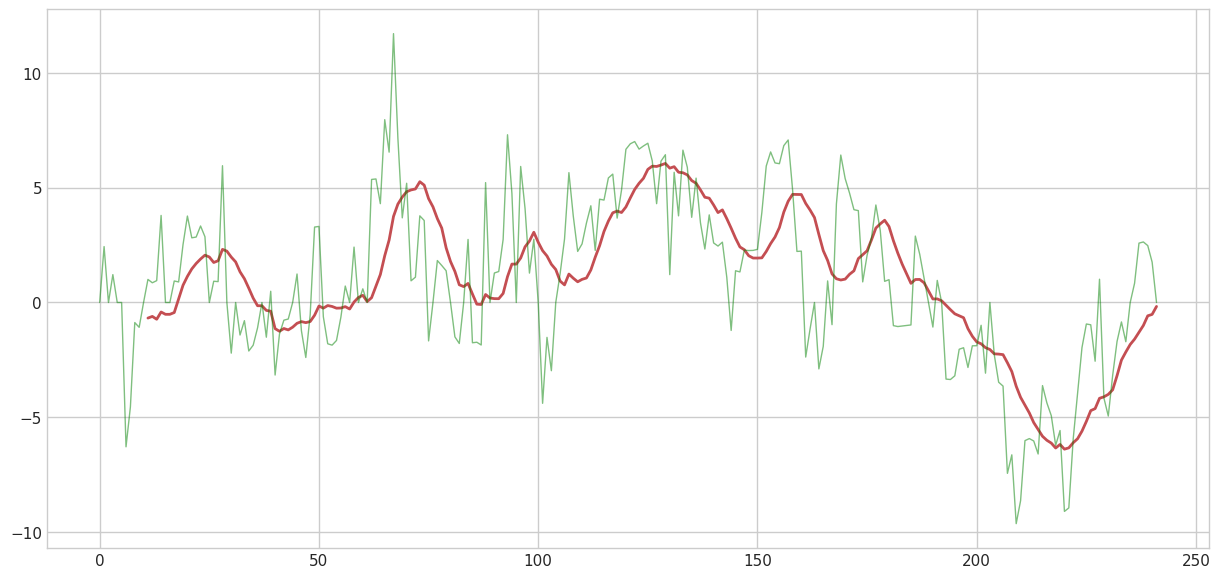

In [176]:
Window = 12
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(df_approach1.index, CompToMA, c = 'r', linewidth= 2)
ax.plot(df_approach1.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)
plt.show()

## Approach 3: sentence evaluation (Gonzalez and Tadle, 2021)

In [44]:
hawkish = ['crédito', 'dólar', 'doméstica', 'domestico', 'moneda nacional', 'demanda', 'actividad económica', 
             'sistema financiero', 'producto alimenticio', 'moneda extranjera', 'divisas', 'economía global', 
             'crecimiento', 'inflación', 'determinante de la inflación', 'pronóstico de inflación', 'financiero internacional', 
             'mercado', 'precio', 'precios', 'recuperación', 'choque de oferta', 'choques de oferta']

#dovish = ['presiones', 'riesgo', 'desaceleración', 'déficit', 'incertidumbre', 'incierto']
dovish = []


positive = ['arriba','acelerar','acelerado', 'acelerada', 'acelera','aceleran','acelerando','acomodar','acomodado','acomoda','acomodando','agregado',
 'aumentar','aumentado','aumentada','aumenta','benigno','mejor','mejores','mejoras','mejoró','grande','impulsar','impulsado','impulsó',
 'brillante','calma','calmado','calmante','calmar','calmó','escala','escalar','escaló','escalando','depreciar','depreciado','deprecia','depreciándose',
 'depreciada', 'dinámica','elevar','elevado','elevados','elevada','eleva','elevan','elevando','elevándose','alentando','escalamiento','escalado','escala',
 'exceder','excedió','exceden','excede', 'excediendo','expande','expandió','expandir','expandiendo','expandido','expandida','expansivo','expansiva','rápido',
 'rápidamente','rapidez','favorable','favorablemente', 'favorece','favoreciendo','favoreció','firme','firmemente','bueno','bien', 'excelente','grande','mayor',
 'mayores','creció','crece','creciendo','crecerá','crecido','saludable','alto','mejorar','mejorado','mejora','mejorando','impulso','impulsado','impulsos','impulsando',
 'aumento','aumentó','aumentar','aumenta','aumentando','inflacionario','grande', 'largo','levantar','levantado',
 'levantando','levanta','suelto','ligero','ligeramente','ligera','máximo','máximos','máxima','máximas','mitigar','mitigado',
 'mitiga','mitigando','más','monto','optimista','supera','superar','superó','superando','pico','picos','positivo','incrementar','incrementó','incrementa',
 'incrementando','incrementos','levantado','levanta','levantando','rampa','rampado','rampante','rampas','rápido','recuperar','recuperado','recuperando','recupera',
 'reforzar','reforzado','refuerza','reforzando','restaurar','restaurado','restaura','alza','alzas','levantado','levanta',
 'levantando','satisfactorio','disparar','disparado','disparándose','disparos','estabilizar','estabiliza','estabilizado','estabilizando','estable','estabilizó',
 'estimula','estimulado','estimulante','estimulación','estimulando','estimulador','fortalece','fortalecer','fortaleció','fortaleciendo','fuerte','fortalecimiento',
 'exitoso','rápido','superior','volcado','repuntes', 'repuntando','vigoroso','ampliar','ancho','ensanchando','ensancha','amplio']

negative = ['adverso','agravar','agravado','agrava','agravando','agravante','apreciar','apreciado','aprecia','apreciando','apreciatorio','malo',
 'preocupación','preocupado','relativo','preocupaciones','conservador','restringir','restringido','restringiendo','restringe','contrato',
 'contraído','contrayendo','contractivo','contrae','corta','corta','corta','amortigua','amortigua','amortigua','amortigua','desacelera','desacelera',
 'desacelera','desacelera','deprimido','deprime','deprimida','disminuye','disminuyó','disminuyendo','disminuiría','disminuirá','disminución',
 'profundiza','profundo','profunda','profundizado','profundizando','profundiza','deflacionario','descender','descendiendo','desciende','descendió',
 'descendente','desestabilizar','desestabilizante','desestabilizador','desestable','desestabilizó','deteriorar','deteriorado','deteriora','deterioro',
 'deteriorando','deteriorada','difícil','disminuir','disminuido','disminuye','disminuyendo','disminución','decepcionante','desinflacionario','dovish','reducción','abajo',
 'abajo','soltar','caer','cayó','caería','cayendo','erosionar','erosionando','erosionar','erosionar','desvanecerse','deterioro', 'deterioró',
 'desvanecerse','falla','fallar','falló','fallando','caer','caído','cayendo','caídas','cayó','menos','aplanar','aplanar',
 'aplanar','aplanar','fluctuar','fluctuado','fluctúa','fluctuante','frágil','daño','dañado','dañando','daña','inconsistente','peligro',
 'peligroso','peligrosa','peligrosos','peligrosas ','peligrosamente','mediocre','menos','menor','bajo','rebajada','rebajado',
 'rebajando','baja','suave','mínimo','mínimos','mínima','mínimas','menores','moderado','moderada','moderados','moderadamente','modera','moderando',
 'moderar','moderarse','modesto','modesta','negativo','pesimista','pobre','recesionario','recesión','recesiva','recortado','recortada',
 'recesivo','reducir ','reducido','reducida','reduce','reduciendo','restrictivo','arriesgado','arriesgado','hundido','hundida','acortar','acortado','acortada','recorte',
 'encoger','encoger','encoge','encogido','encogido','fregadero','hundimiento','lento','lenta','lentos','lentas','lentamente','ralentizado','ralentizada','pequeño',
 'pequeña','ínfimo','pequeños','pequeñas','suavizar','suavizado','suave','suavizando','especular','especuló','especulando','especulativo','especulativa','estresar',
 'estresado','estresando', 'estresada','estresaría','estricto','estrictos','moderado','hundido','hundida','suprimir','suprimido','suprime','suprimiendo','amenazar',
 'amenazado ','amenazante','amenaza','apretar ','apretado','apretando','apretando','más apretado','más duro','turbulento','incierto','socavar','desfavorable',
 'desfavorables','desfavoreciendo','inestable','volátil','vulnerable','débil','debilitar','debilitado','debilitando','debilita','débil','peor','empeorar',
 'empeorando','empeoramiento','empeorararía','peor','empeoró','empeore']

In [45]:
# Main dictionary
lmdict = {'hawkish': hawkish, 'dovish':dovish, 'positive': positive, 'negative': negative}

In [46]:
def tone_count_sentence_evaluation(dict, doc):
    tone_score_list = []
    words_count_list = []
    haw_words = []
    dov_words = []
    pos_words = []
    neg_words = []

    sentences = doc.lower().split('.')
    sentences_count = len(sentences)

    for sentence in sentences:
        sentence_score = 0
        haw_count = 0
        dov_count = 0
        pos_count = 0
        neg_count = 0

        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', sentence.lower())
        words_count = len(input_words)
        words_count_list.append(words_count)

        for i in range(0, words_count):
            if input_words[i] in dict['hawkish']:
                haw_count += 1
                haw_words.append(input_words[i])
            if input_words[i] in dict['dovish']:
                dov_count += 1
                dov_words.append(input_words[i])
            if input_words[i] in dict['positive']:
                pos_count += 1
                pos_words.append(input_words[i])
            if input_words[i] in dict['negative']:
                neg_count += 1
                neg_words.append(input_words[i])

        if (words_count > 0): #and (haw_count != 0 and dov_count != 0):
            if haw_count > dov_count:
                if pos_count > neg_count:
                    sentence_score = 1
                    tone_score_list.append(sentence_score)
                elif pos_count == neg_count:
                    sentence_score = 0
                    tone_score_list.append(sentence_score)
                elif pos_count < neg_count:
                    sentence_score = -1
                    tone_score_list.append(sentence_score)
            elif haw_count == dov_count:
                if pos_count > neg_count:
                    sentence_score = 1
                    tone_score_list.append(sentence_score)
                elif pos_count == neg_count:
                    sentence_score = 0
                    tone_score_list.append(sentence_score)
                elif pos_count < neg_count:
                    sentence_score = -1
                    tone_score_list.append(sentence_score)
            elif haw_count < dov_count:
                if pos_count > neg_count:
                    sentence_score = -1
                    tone_score_list.append(sentence_score)
                elif pos_count == neg_count:
                    sentence_score = 0
                    tone_score_list.append(sentence_score)
                elif pos_count < neg_count:
                    sentence_score = 1
                    tone_score_list.append(sentence_score)
        else:
            sentence_score = 0
            tone_score_list.append(sentence_score)
        
    results = [100*sum(tone_score_list)/sentences_count, sentences_count, sum(words_count_list), haw_words, dov_words, pos_words, neg_words]
    return results

columns = ['tone_GT', 'sentence_count', 'word_count', 'haw_words', 'dov_words', 'pos_modifiers', 'neg_modifiers']

In [47]:
# Analyze tone for original text dataframe
print(df_text.shape)
tone_lmdict = [tone_count_sentence_evaluation(lmdict, x) for x in tqdm(df_text['text'], total=df_text.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
tone_lmdict_df['Index'] = range(0, len(tone_lmdict_df))
df_approach2 = pd.merge(df_text, tone_lmdict_df, on='Index')
df_approach2

(242, 4)


/tmp/ipykernel_1426/565467864.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tone_lmdict = [tone_count_sentence_evaluation(lmdict, x) for x in tqdm(df_text['text'], total=df_text.shape[0])]


  0%|          | 0/242 [00:00<?, ?it/s]

,statement,date,text,Index,tone_GT,sentence_count,word_count,haw_words,dov_words,pos_modifiers,neg_modifiers
0,Nota-Informativa-001-2003-BCRP.pdf,2003-01-01,Nota de Prensa DIRECTORIO DEL BCR APR...,0,0.000000,16,391,"[demanda, mercado, crecimiento, demanda, creci...",[],"[arriba, inflacionario, alza, alza]","[menor, abajo, baja]"
1,Nota-Informativa-002-2003-BCRP.pdf,2003-02-01,Nota de Prensa DIRECTORIO DEL BCR APR...,1,5.263158,19,327,"[mercado, mercado, precios, precios, crecimien...",[],"[alza, arriba, aumento]","[abajo, baja]"
2,Nota-Informativa-003-2003-BCRP.pdf,2003-03-01,Nota de Prensa DIRECTORIO DEL BCR APR...,2,16.666667,18,329,"[precios, precios, precios, precio, precios, m...",[],"[aumento, inflacionario, alza, alza, arriba]",[abajo]
3,Nota-Informativa-004-2003-BCRP.pdf,2003-04-01,Nota de Prensa PROGRAMA MONETARIO ...,3,14.285714,21,328,"[precios, precios, precios, precios, mercado]",[],"[aumento, alzas, arriba, superior, mayor]",[abajo]
4,Nota-Informativa-005-2003-BCRP.pdf,2003-05-01,Nota de Prensa DIRECTORIO DEL BCR ...,4,-5.000000,20,314,"[precios, precios, precios, crecimiento, preci...",[],[arriba],"[menores, abajo]"
...,...,...,...,...,...,...,...,...,...,...,...
237,nota-informativa-2022-10-06-1.pdf,2022-10-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE OCTUBRE...,237,24.000000,25,462,"[precios, precios, precios, crecimiento, creci...",[],"[eleva, elevar, alzas, superior, aumento, fuer...","[pesimista, disminuyendo, menor, bajo]"
238,nota-informativa-2022-11-10-1.pdf,2022-11-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE NOVIEMB...,238,20.000000,25,453,"[precios, precios, crecimiento, crecimiento]",[],"[eleva, elevar, superior, aumento, fuerte, sup...","[pesimista, disminuyendo, menor, bajo]"
239,nota-informativa-2022-12-07-1.pdf,2022-12-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE DICIEMB...,239,16.666667,24,482,"[precios, precios, crecimiento, crecimiento]",[],"[eleva, elevar, superior, aumento, fuerte, sup...","[pesimista, disminuyendo, menor, bajo]"
240,nota-informativa-2023-01-12-1.pdf,2023-01-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE ENERO 2...,240,20.000000,25,453,"[precios, precios, precios, crecimiento]",[],"[eleva, elevar, mayores, superior, aumento, fu...","[pesimista, disminuyendo, bajo]"


## Approach 2: Cosine Similarity (tokenization and lemmatization)

In [134]:
import spacy
import spacy_spanish_lemmatizer
from tqdm import tqdm 

nlp = spacy.load('es_core_news_sm', exclude=["ner"])
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop = list(nlp.Defaults.stop_words)

#spanish
def spacy_lemmatizer(word):
    token = nlp(word)
    for word in token:
        return word.lemma_

#english
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

#english
def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it lower case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized

#spanish
def spacy_tokenizer(df, col='text', nlp=nlp):

  docs = nlp.pipe(df[col]) # more efficient, delete lists once processed
  new_stop = ['nota', 'prensa', 'directorio', 'del', 'bcr', 'bcrp','aprobó', 'programa', 'monetario', 'para', 'el', 'mes', 'de',
              'enero','febrero','marzo','abril','mayo','junio','julio','agosto','setiembre','septiembre','octubre','noviembre','diciembre',
              'ciento', 'mes','sesión','lima','informativa']
  tokenized = []
  #wnl = nltk.stem.WordNetLemmatizer()
  for doc in tqdm(docs, total=len(df[col])):
      # Lemmatize words
      tokens = [token.lemma_ for token in doc]
      # Stop words and alphabetic filter
      tokens = [tok.lower() for tok in tokens if ((tok not in stop) and (tok.isalpha()==1)) and (tok not in new_stop)]
      tokenized.append(tokens)
  return tokenized

#### Tokenize df_text

In [127]:
tokenized_org = spacy_tokenizer(df_text)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])

100%|██████████| 242/242 [00:45<00:00,  5.37it/s]

len(tokenized_org):  242
['aprobar', 'reducir', 'tasa', 'interés', 'crédito', 'regulación', 'operaciones', 'compra', 'directo', 'temporal', 'título', 'valor', 'mantener', 'tasa', 'interés', 'depósito', 'overnight', 'proyectar', 'saldo', 'promedio', 'corriente', 'banca', 'millón', 'tomar', 'menor', 'demanda', 'liquidez', 'estacionalmente', 'observar', 'precisar', 'tasa', 'interés', 'crédito', 'regulación', 'operaciones', 'compra', 'directo', 'temporal', 'título', 'valor', 'tasa', 'interés', 'mercado', 'interbancario', 'superar', 'decisión', 'política', 'orientar', 'lograr', 'inflación', 'acumulado', 'anual', 'rango', 'tolerancia', 'punto', 'porcentual', 'abajo', 'tasa', 'inflación', 'margen', 'inferior', 'meta', 'encuestas', 'entidad', 'financiero', 'analistas', 'económico', 'revelar', 'tasa', 'inflación', 'esperado', 'elevación', 'tipo', 'cambio', 'crecimiento', 'anual', 'pbi', 'llegar', 'demanda', 'interna', 'mantener', 'perspectiva', 'favorable', 'evolución', 'actividad', 'económico'

In [128]:
df_text['text'][0]

'         Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGRAMA MONETARIO PARA EL MES DE ENERO DE 2003. El Directorio del BCR aprobó reducir de 4,50 a 4,25 por ciento la tasa de interés para los créditos de regulación monetaria y operaciones de compra directa temporal de títulos valores, manteniendo en 3,0 por ciento la tasa de interés de los depósitos overnight. Para este mes se proyecta un saldo promedio de las cuentas corrientes de la banca en el BCR de 170 a 190 millones, tomando en cuenta la menor demanda de liquidez que estacionalmente se observa en los meses de enero. Se precisa que la tasa de interés para los créditos de regulación monetaria y operaciones de compra directa temporal de títulos valores será igual a la tasa de interés del mercado interbancario cuando esta última supere 4,25 por ciento. Las decisiones de política monetaria se orientan a lograr que la inflación acumulada anual sea 2,5 por ciento, con un rango de tolerancia de un punto porcentual hacia arriba y hacia aba

In [129]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  242
aprobar reducir tasa interés crédito regulación operaciones compra directo temporal título valor mantener tasa interés depósito overnight proyectar saldo promedio corriente banca millón tomar menor demanda liquidez estacionalmente observar precisar tasa interés crédito regulación operaciones compra directo temporal título valor tasa interés mercado interbancario superar decisión política orientar lograr inflación acumulado anual rango tolerancia punto porcentual abajo tasa inflación margen inferior meta encuestas entidad financiero analistas económico revelar tasa inflación esperado elevación tipo cambio crecimiento anual pbi llegar demanda interna mantener perspectiva favorable evolución actividad económico entorno inflación encuestas entidad financiero analistas económico mostrar crecimiento pbi corto plazo principal fuente riesgo inflacionario alza precio internacional petróleo aumentar entorno externo volátil medida alza replicar resto precio internos requ

In [130]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabulary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['inflación']: ", vocab_org['inflación'])
print("vocab_org['crecimiento']: ", vocab_org['crecimiento'])

len(all_words_org):  42982
aprobar
len(counts_org):  1264
bow_org[:20] ['tasa', 'inflación', 'interés', 'mantener', 'operaciones', 'anual', 'referencia', 'meta', 'rango', 'temporal', 'actividad', 'compra', 'indicador', 'financiero', 'crédito', 'económico', 'expectativa', 'ubicar', 'política', 'precio']
vocab_org['inflación']:  36
vocab_org['crecimiento']:  57


In [131]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

242


In [132]:
# Add to the dataframe
df_approach3 = df_text.copy(deep=True)
df_approach3['tokenized'] = tokenized_org
df_approach3['token_ids'] = token_ids_org
df_approach3

,statement,date,text,Index,tokenized,token_ids
0,Nota-Informativa-001-2003-BCRP.pdf,2003-01-01,Nota de Prensa DIRECTORIO DEL BCR APR...,0,"[aprobar, reducir, tasa, interés, crédito, reg...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3,..."
1,Nota-Informativa-002-2003-BCRP.pdf,2003-02-01,Nota de Prensa DIRECTORIO DEL BCR APR...,1,"[aprobar, mantener, tasa, interés, operaciones...","[1, 13, 3, 4, 7, 99, 100, 5, 6, 7, 8, 9, 10, 1..."
2,Nota-Informativa-003-2003-BCRP.pdf,2003-03-01,Nota de Prensa DIRECTORIO DEL BCR APR...,2,"[tasa, inflación, principalmente, incremento, ...","[3, 36, 115, 116, 74, 134, 135, 136, 137, 119,..."
3,Nota-Informativa-004-2003-BCRP.pdf,2003-04-01,Nota de Prensa PROGRAMA MONETARIO ...,3,"[tasa, inflación, explicado, principalmente, f...","[3, 36, 114, 115, 149, 150, 119, 74, 120, 151,..."
4,Nota-Informativa-005-2003-BCRP.pdf,2003-05-01,Nota de Prensa DIRECTORIO DEL BCR ...,4,"[tasa, inflación, explicado, principalmente, r...","[3, 36, 114, 115, 169, 74, 134, 3, 36, 139, 15..."
...,...,...,...,...,...,...
237,nota-informativa-2022-10-06-1.pdf,2022-10-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE OCTUBRE...,237,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,..."
238,nota-informativa-2022-11-10-1.pdf,2022-11-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE NOVIEMB...,238,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,..."
239,nota-informativa-2022-12-07-1.pdf,2022-12-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE DICIEMB...,239,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,..."
240,nota-informativa-2023-01-12-1.pdf,2023-01-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE ENERO 2...,240,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,..."


/tmp/ipykernel_1426/672648244.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_approach3['tokenized_text'].apply(lambda x: len(x.split())))


<AxesSubplot:xlabel='tokenized_text', ylabel='Density'>

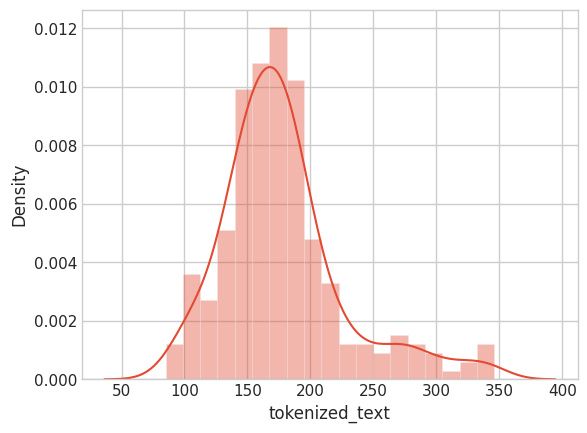

In [133]:
df_approach3['tokenized_text'] = df_approach3['tokenized'].apply(lambda x: " ".join(x))
sns.distplot(df_approach3['tokenized_text'].apply(lambda x: len(x.split())))

### Lemmatize sentiment

In [138]:
# pd.get_dummies(sentiment_spanish, prefix=None, dtype=bool)
# sentiment_spanish.columns = [column.lower() for column in sentiment_spanish.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_spanish.copy()
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_spanish.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [140]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
negative,1525
positive,332


### Tfidf

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

#### Text Dataframe

In [148]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['negative']))
print(len(sentiment_tfidf_org['negative'][0]))

242
1525


/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [149]:
df_approach3.shape

(242, 7)

In [150]:
for sentiment in lemma_sentiments:
    df_approach3['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
df_approach3

,statement,date,text,Index,tokenized,token_ids,tokenized_text,tfidf_negative,tfidf_positive
0,Nota-Informativa-001-2003-BCRP.pdf,2003-01-01,Nota de Prensa DIRECTORIO DEL BCR APR...,0,"[aprobar, reducir, tasa, interés, crédito, reg...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3,...",aprobar reducir tasa interés crédito regulació...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5159734164044701, 0.0, ..."
1,Nota-Informativa-002-2003-BCRP.pdf,2003-02-01,Nota de Prensa DIRECTORIO DEL BCR APR...,1,"[aprobar, mantener, tasa, interés, operaciones...","[1, 13, 3, 4, 7, 99, 100, 5, 6, 7, 8, 9, 10, 1...",aprobar mantener tasa interés operaciones acti...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5670492210592937, 0.0, ..."
2,Nota-Informativa-003-2003-BCRP.pdf,2003-03-01,Nota de Prensa DIRECTORIO DEL BCR APR...,2,"[tasa, inflación, principalmente, incremento, ...","[3, 36, 115, 116, 74, 134, 135, 136, 137, 119,...",tasa inflación principalmente incremento preci...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8080789737491322, 0.0, ..."
3,Nota-Informativa-004-2003-BCRP.pdf,2003-04-01,Nota de Prensa PROGRAMA MONETARIO ...,3,"[tasa, inflación, explicado, principalmente, f...","[3, 36, 114, 115, 149, 150, 119, 74, 120, 151,...",tasa inflación explicado principalmente factor...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Nota-Informativa-005-2003-BCRP.pdf,2003-05-01,Nota de Prensa DIRECTORIO DEL BCR ...,4,"[tasa, inflación, explicado, principalmente, r...","[3, 36, 114, 115, 169, 74, 134, 3, 36, 139, 15...",tasa inflación explicado principalmente reducc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
237,nota-informativa-2022-10-06-1.pdf,2022-10-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE OCTUBRE...,237,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
238,nota-informativa-2022-11-10-1.pdf,2022-11-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE NOVIEMB...,238,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
239,nota-informativa-2022-12-07-1.pdf,2022-12-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE DICIEMB...,239,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
240,nota-informativa-2023-01-12-1.pdf,2023-01-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE ENERO 2...,240,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Cosine Similarity

Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [151]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [152]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf_org.items()}

print(len(cosine_similarities['negative']))

241


In [153]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    df_approach3['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
df_approach3

,statement,date,text,Index,tokenized,token_ids,tokenized_text,tfidf_negative,tfidf_positive,cos_sim_negative,cos_sim_positive
0,Nota-Informativa-001-2003-BCRP.pdf,2003-01-01,Nota de Prensa DIRECTORIO DEL BCR APR...,0,"[aprobar, reducir, tasa, interés, crédito, reg...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3,...",aprobar reducir tasa interés crédito regulació...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5159734164044701, 0.0, ...",0.000000,0.000000
1,Nota-Informativa-002-2003-BCRP.pdf,2003-02-01,Nota de Prensa DIRECTORIO DEL BCR APR...,1,"[aprobar, mantener, tasa, interés, operaciones...","[1, 13, 3, 4, 7, 99, 100, 5, 6, 7, 8, 9, 10, 1...",aprobar mantener tasa interés operaciones acti...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5670492210592937, 0.0, ...",0.291775,0.814286
2,Nota-Informativa-003-2003-BCRP.pdf,2003-03-01,Nota de Prensa DIRECTORIO DEL BCR APR...,2,"[tasa, inflación, principalmente, incremento, ...","[3, 36, 115, 116, 74, 134, 135, 136, 137, 119,...",tasa inflación principalmente incremento preci...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8080789737491322, 0.0, ...",0.372568,0.701725
3,Nota-Informativa-004-2003-BCRP.pdf,2003-04-01,Nota de Prensa PROGRAMA MONETARIO ...,3,"[tasa, inflación, explicado, principalmente, f...","[3, 36, 114, 115, 149, 150, 119, 74, 120, 151,...",tasa inflación explicado principalmente factor...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.553511,0.295240
4,Nota-Informativa-005-2003-BCRP.pdf,2003-05-01,Nota de Prensa DIRECTORIO DEL BCR ...,4,"[tasa, inflación, explicado, principalmente, r...","[3, 36, 114, 115, 169, 74, 134, 3, 36, 139, 15...",tasa inflación explicado principalmente reducc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.812679,0.641059
...,...,...,...,...,...,...,...,...,...,...,...
237,nota-informativa-2022-10-06-1.pdf,2022-10-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE OCTUBRE...,237,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.915267,0.953212
238,nota-informativa-2022-11-10-1.pdf,2022-11-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE NOVIEMB...,238,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.981433
239,nota-informativa-2022-12-07-1.pdf,2022-12-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE DICIEMB...,239,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1.000000
240,nota-informativa-2023-01-12-1.pdf,2023-01-01,NOTA INFORMATIVA PROGRAMA MONETARIO DE ENERO 2...,240,"[elevar, tasa, interés, referencia, banco, cen...","[264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...",elevar tasa interés referencia banco central r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.975875


In [64]:
#df_text.to_csv(data_path+'/sentiment_peru_3.csv',index=False)

## Unify main features in df_merged

In [154]:
df_approach1 = df_approach1[['Index','tone_LM']]
df_approach2 = df_approach2[['Index','tone_GT']]
df_approach3 = df_approach3[['Index','tokenized','token_ids','tokenized_text','tfidf_negative','tfidf_positive','cos_sim_negative','cos_sim_positive']]

data_frames = [df_text, df_approach1, df_approach2, df_approach3]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Index'], how='outer'), data_frames)
df_merged = df_merged.set_index(pd.to_datetime(df_merged['date'], format="%Y-%m-%d")).drop(columns=['date','Index'])
df_merged.to_csv(data_path+'/text_sentiment_data_per.csv', index_label=False)
df_merged.head()

,statement,text,tone_LM,tone_GT,tokenized,token_ids,tokenized_text,tfidf_negative,tfidf_positive,cos_sim_negative,cos_sim_positive
date,,,,,,,,,,,
2003-01-01,Nota-Informativa-001-2003-BCRP.pdf,Nota de Prensa DIRECTORIO DEL BCR APR...,0.000000,0.000000,"[aprobar, reducir, tasa, interés, crédito, reg...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3,...",aprobar reducir tasa interés crédito regulació...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5159734164044701, 0.0, ...",0.000000,0.000000
2003-02-01,Nota-Informativa-002-2003-BCRP.pdf,Nota de Prensa DIRECTORIO DEL BCR APR...,0.611621,5.263158,"[aprobar, mantener, tasa, interés, operaciones...","[1, 13, 3, 4, 7, 99, 100, 5, 6, 7, 8, 9, 10, 1...",aprobar mantener tasa interés operaciones acti...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5670492210592937, 0.0, ...",0.291775,0.814286
2003-03-01,Nota-Informativa-003-2003-BCRP.pdf,Nota de Prensa DIRECTORIO DEL BCR APR...,0.000000,16.666667,"[tasa, inflación, principalmente, incremento, ...","[3, 36, 115, 116, 74, 134, 135, 136, 137, 119,...",tasa inflación principalmente incremento preci...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8080789737491322, 0.0, ...",0.372568,0.701725
2003-04-01,Nota-Informativa-004-2003-BCRP.pdf,Nota de Prensa PROGRAMA MONETARIO ...,0.304878,14.285714,"[tasa, inflación, explicado, principalmente, f...","[3, 36, 114, 115, 149, 150, 119, 74, 120, 151,...",tasa inflación explicado principalmente factor...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.553511,0.295240
2003-05-01,Nota-Informativa-005-2003-BCRP.pdf,Nota de Prensa DIRECTORIO DEL BCR ...,0.000000,-5.000000,"[tasa, inflación, explicado, principalmente, r...","[3, 36, 114, 115, 169, 74, 134, 3, 36, 139, 15...",tasa inflación explicado principalmente reducc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.812679,0.641059
